In [1]:
import numpy as np
import matplotlib.pyplot as plt
import opensimplex
from ipywidgets import interact
import ipywidgets as widgets
import random
from scipy.spatial.distance import pdist
from numpy.lib.stride_tricks import sliding_window_view
from itertools import product

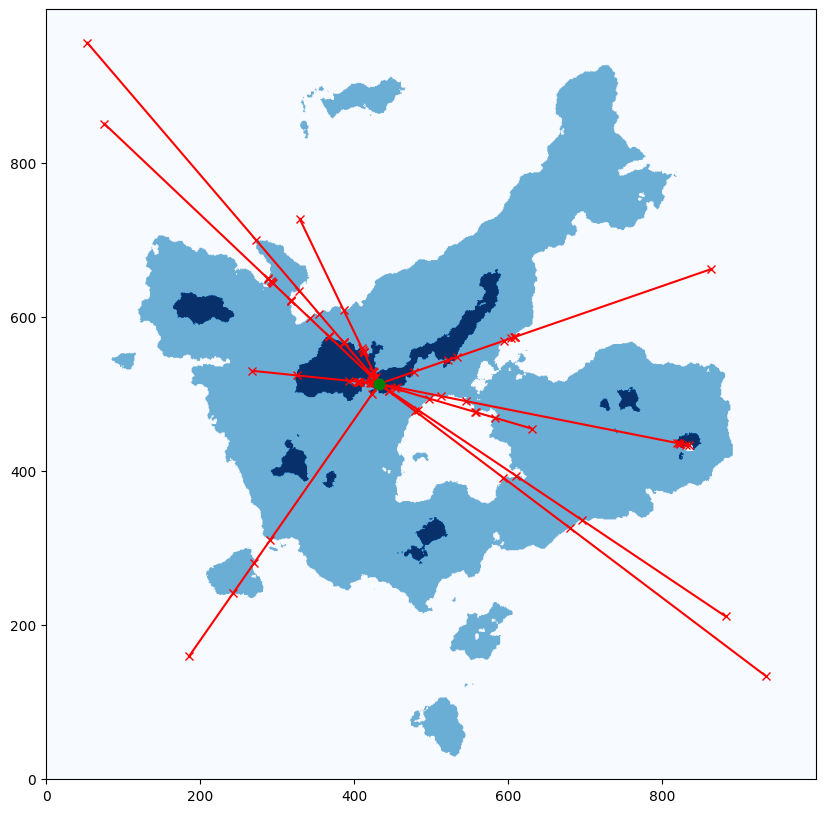

interactive(children=(IntSlider(value=1, description='senders', max=3, min=-1), IntSlider(value=10, descriptio…

<function __main__.generate(senders=1, receivers=10, show_signal_paths=True, highlight_senders=True, sender_in_city=True, **map_config)>

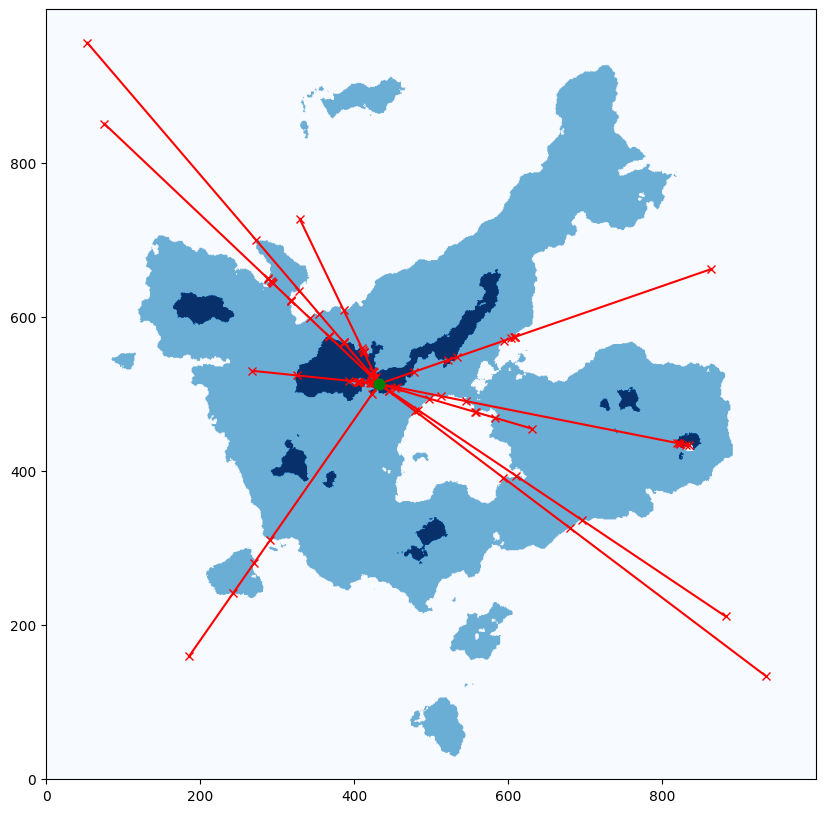

In [47]:
def create_map(
    freq=1,
    map_resolution=100,
    octaves=1,
    octave_factor=2,
    redistribution=1,
    levels=3,
    island=False,
):
    # Initialize map
    z = np.zeros((map_resolution, map_resolution))

    # Apply noise maps with different frequencies
    of = 1
    for _ in range(octaves):
        x, y = np.linspace(freq * of * -1, freq * of * 1, map_resolution), np.linspace(
            freq * of * -1, freq * of * 1, map_resolution
        )
        z += (1 / of) * opensimplex.noise2array(x, y)
        of *= octave_factor

    # Enable population islands
    znorm = (2 * (z - np.min(z)) / (np.max(z) - np.min(z))) - 1  # norm from -1 to 1
    _b = np.linspace(-1, 1, map_resolution)
    _x, _y = np.meshgrid(_b, _b)
    d = -(1 - ((1 - _x**2) * (1 - _y**2)))
    if island:
        d *= -1
    z = (znorm + (1 - d)) / 2

    # Control diff between peaks and troughs
    z = (z - np.min(z)) / (np.max(z) - np.min(z))  # norm from 0 to 1
    z = np.power(z, redistribution)

    # Quantize to specific terrain levels
    z = np.digitize(z, np.linspace(z.min(), z.max() + 0.0000001, levels + 1))
    z = (z - np.min(z)) / (np.max(z) - np.min(z))  # norm from 0 to 1

    return z


def resolve_map(pop_map, foliage_map):
    assert pop_map.shape == foliage_map.shape
    map = np.ones(pop_map.shape)
    map[pop_map == 0] = 1  # Terrain
    map[
        np.where(
            (pop_map > 0.3) & (pop_map < 0.8) & (foliage_map >= 0) & (foliage_map < 0.6)
        )
    ] = 2  # Suburban
    map[np.where((pop_map >= 0.8) & (foliage_map <= 0.5))] = 3  # City
    return map


def create_nodes(senders, recievers, sender_in_city, map, map_resolution):
    if sender_in_city:
        city_points = np.stack(np.where(map == 3)).T
        senders = city_points[np.random.randint(len(city_points), size=(senders)), :]
        senders[:, [0, 1]] = senders[
            :, [1, 0]
        ]  # Swap colums for consistency during unpack
    else:
        senders = np.random.randint(map_resolution, size=(senders, 2))
    recievers = np.random.randint(map_resolution, size=(recievers, 2))
    return senders, recievers


def compute_distances(senders, recievers, map, distance_metric="euclidean"):
    distance_data = []
    for sender, reciever in product(senders, recievers):
        xSender, ySender = sender
        xReciever, yReciever = reciever
        num = 10000
        # Evaluate points between sender and reciever
        x, y = np.linspace(xSender, xReciever, num), np.linspace(
            ySender, yReciever, num
        )
        # Extract the values along the line
        zi = map[y.astype(int), x.astype(int)]
        terrain_transitions = (np.abs(zi[1:] - zi[:-1]) > 0).astype(int)
        terrain_transitions = np.concatenate([np.array([0]), terrain_transitions])
        xtrans_coords, ytrans_coords = (
            x[terrain_transitions == 1],
            y[terrain_transitions == 1],
        )
        xtrans_coords = np.concatenate([[xSender], xtrans_coords, [xReciever]])
        ytrans_coords = np.concatenate([[ySender], ytrans_coords, [yReciever]])
        # terrain type between last transition and reciever is the same
        terrain_types = map[ytrans_coords.astype(int), xtrans_coords.astype(int)][:-1]
        key_points = np.stack([xtrans_coords, ytrans_coords]).T
        point_pairs = sliding_window_view(key_points, 2, axis=0)
        distances = [pdist(pair, metric=distance_metric) for pair in point_pairs]
        distance_data.append(
            {
                "key_points": key_points,
                "reciever_coords": reciever,
                "sender_coords": sender,
                "terrain_type": terrain_types,
                "distances": distances,
            }
        )
    return distance_data


def plot_map(map, distance_data, show_signal_paths, highlight_senders):
    fig, axes = plt.subplots(nrows=1, figsize=(10, 10))
    axes.imshow(map, origin="lower", cmap="Blues")
    if not show_signal_paths:
        plt.show()
        return

    for d in distance_data:
        key_points = d["key_points"]
        xtrans_coords, ytrans_coords = key_points[:, 0], key_points[:, 1]
        xSender, ySender = d["sender_coords"]
        axes.plot(xtrans_coords, ytrans_coords, "rx-", zorder=0)
        if highlight_senders:
            axes.scatter(xSender, ySender, marker="o", color="g", s=50, zorder=10)

        axes.axis("image")

    fig.colorbar()
    plt.show()
    return fig


def generate(
    senders=1,
    receivers=10,
    show_signal_paths=True,
    highlight_senders=True,
    sender_in_city=True,
    **map_config,
):
    opensimplex.seed(1234)
    np.random.seed(4123)
    random.seed(123431)

    pop_map = create_map(
        map_config["pop_freq"],
        map_config["map_resolution"],
        map_config["pop_octaves"],
        map_config["pop_octaves_factor"],
        map_config["pop_redistribution"],
        map_config["pop_levels"],
        island=True,
    )
    foliage_map = create_map(
        map_config["foliage_freq"],
        map_config["map_resolution"],
        map_config["foliage_octaves"],
        map_config["foliage_octaves_factor"],
        map_config["foliage_redistribution"],
        map_config["foliage_levels"],
    )
    map = resolve_map(pop_map, foliage_map)

    senders, recievers = create_nodes(
        senders, receivers, sender_in_city, map, map_config["map_resolution"]
    )
    distance_data = compute_distances(senders, recievers, map)
    plot_map(map, distance_data, show_signal_paths, highlight_senders)


default_map_config = {
    "map_resolution": 1000,
    "foliage_freq": 10,
    "foliage_octaves": 3,
    "foliage_octaves_factor": 6,
    "foliage_levels": 10,
    "foliage_redistribution": 2.2,
    "pop_octaves": 10,
    "pop_freq": 2.6,
    "pop_octaves_factor": 2.61,
    "pop_levels": 11,
    "pop_redistribution": 2.40,
}

interact(
    generate,
    map_resolution=widgets.IntSlider(min=100, max=1000, step=1, value=default_map_config["map_resolution"]),
    foliage_freq=widgets.FloatSlider(min=1, max=10, step=0.1, value=default_map_config["foliage_freq"]),
    foliage_octaves=widgets.IntSlider(min=1, max=10, step=1, value=default_map_config["foliage_octaves"]),
    foliage_octaves_factor=widgets.FloatSlider(min=1, max=10, step=0.1, value=default_map_config["foliage_octaves_factor"]),
    foliage_levels=widgets.IntSlider(min=0, max=10, step=0.1, value=default_map_config["foliage_levels"]),
    foliage_redistribution=widgets.FloatSlider(min=0, max=10, step=0.1, value=default_map_config["foliage_redistribution"]),
    pop_octaves=widgets.IntSlider(min=1, max=10, step=1, value=default_map_config["pop_octaves"]),
    pop_freq=widgets.FloatSlider(min=1, max=10, step=0.1, value=default_map_config["pop_freq"]),
    pop_octaves_factor=widgets.FloatSlider(min=1, max=3, step=0.01, value=default_map_config["pop_octaves_factor"]),
    pop_levels=widgets.IntSlider(min=2, max=20, step=0.1, value=default_map_config["pop_levels"]),
    pop_redistribution=widgets.FloatSlider(min=0, max=10, step=0.1, value=default_map_config["pop_redistribution"]),
)

In [5]:
# open 
# city
# foliage
# 